# 1. Preparación de los datos

Word2Vec no aprende de texto crudo. Necesitamos que nuestros datos estén en un formato específico: una lista de listas, donde cada sub-lista es una oración tokenizada (dividida en palabras).

Por ejemplo:

**Texto crudo**: `"Hola, este es mi primer documento"`

**Formato Requerido**: `[['hola'], ['este'], ['es'], ['mi'], ['primer'], ['documento']]`

In [1]:
import re
import nltk
from nltk.tokenize import word_tokenize

# Sólo se descomenta si es primera ejecución
# nltk.download('punkt_tab')

# Nuestros textos (documentos)

documentos = ["Este es el proyecto de embeddings",
          "Quiero entrenar un modelo Word2Vec con mis propias palabras",
          "Un buen procesamiento es importante para buenos embeddings",
          "La inteligencia artificial y el procesamiento de lenguaje natural son interesantes"]

# Función simple de preprocesamiento
def preproc(texto):
  # Convertir a minúsculas
  texto = texto.lower()
  # Quitar puntuación y números
  texto = re.sub(r'[^a-záéíóúñ\s]', '', texto)
  # Tokenizar (dividir en palabras)
  tokens = word_tokenize(texto, language = 'spanish')
  return tokens

# Aplicamos el preprocesaminto a todos nuestros textos
datos_preprocesados = [preproc(texto) for texto in documentos]

# Imprimimos el resultado para verificar
print(datos_preprocesados)

[['este', 'es', 'el', 'proyecto', 'de', 'embeddings'], ['quiero', 'entrenar', 'un', 'modelo', 'wordvec', 'con', 'mis', 'propias', 'palabras'], ['un', 'buen', 'procesamiento', 'es', 'importante', 'para', 'buenos', 'embeddings'], ['la', 'inteligencia', 'artificial', 'y', 'el', 'procesamiento', 'de', 'lenguaje', 'natural', 'son', 'interesantes']]


# 2. Entrenamiento del Modelo Word2Vec

In [2]:
!pip install gensim

In [3]:
from gensim.models import Word2Vec
import multiprocessing

# 1. Iniciamos el modelo
model = Word2Vec(
    sentences = datos_preprocesados, # Nuestos datos tokenizados
    vector_size = 100,               # Dimensión de los embeddings (100-300 es común)
    window = 5,                      # Tamaño de la ventana de contexto
    min_count = 1,                   # Ignorar palabras con frecuencia menor a esta
    workers = multiprocessing.cpu_count() -1, # Usar casi todos los cores de la CPU
    sg = 0                           # Algoritmo: 0 para CBOW (default), 1 para Skip-Gram
)

# 2. (Opcional) Construir el vocabulario (Gensim > 4.0 lo hace automático)
model.build_vocab(datos_preprocesados)

# 3. Entrenar el modelo
model.train(datos_preprocesados, total_examples = model.corpus_count, epochs = 10)

print("Modelo entrenado")

Modelo entrenado


# 3. Explorando los Embeddings

Ahora podemos ver lo que aprendió el modeo

In [4]:
# Obtener el vector para una palabra específica
try:
  vector_palabra = model.wv['inteligencia']
  print(f"Vector para nuestra palabra: \n {vector_palabra} \n")
except KeyError:
  print("La palabra no está en el vocabulario \n")

# Encontramos las palabras más similares
try:
  similares = model.wv.most_similar('embeddings', topn = 5)
  print(f"Palabras más similares a la palabra: \n {similares} \n")
except KeyError:
  print("La palabra no está en el vocabulario")

# También podemos hacer analogías (ej. "rey" es a "hombre" como "reina" es a "mujer")
# model.wv.most_similar(positive = ['mujer', 'rey'], negative = ['hombre'])

Vector para nuestra palabra: 
 [ 1.3318050e-03  6.5414351e-03  9.9926041e-03  9.0682562e-03
 -8.0248695e-03  6.4909798e-03 -5.7078172e-03 -9.6612575e-04
  4.8071300e-04  6.5758815e-03  4.4692205e-03  4.5999368e-03
  9.4839763e-03  3.8630984e-04 -6.0430872e-03 -6.3283960e-03
  6.4344821e-03 -5.2421149e-03 -2.8563277e-03  4.0655523e-03
 -2.2923029e-03 -6.0164351e-03 -2.3299633e-03  1.2059958e-03
  2.1773512e-03  6.0887048e-03 -5.2171671e-03  3.0748376e-03
  7.2405841e-03  2.1971888e-03  5.3944332e-03 -4.8479894e-03
  6.1591244e-03 -7.5987000e-03  3.4845811e-03 -9.3161389e-03
 -2.6034710e-03 -9.0840813e-03 -1.5918420e-03 -5.3674951e-03
 -3.9422102e-03  1.1593759e-03  2.8008313e-03 -1.5215677e-03
 -8.1676701e-03 -5.9200595e-03  8.1640645e-04 -3.9540324e-03
 -9.4244936e-03 -7.7317416e-04  6.6264528e-03  5.9768734e-03
 -9.9200383e-03  3.1174431e-03 -5.9817163e-03 -9.1749206e-03
  1.7429165e-04 -3.6883994e-04 -6.9615790e-03 -6.2733721e-03
 -2.4255745e-03  7.0908372e-03 -7.5451732e-03  7.69739

# 4. Guardar y Cargar el Modelo

In [5]:
# Guardamos el modelo entrenado
model.save("modelo_word2vec.model")

# Cargamos el modelo en otro script
model_cargado = Word2Vec.load("modelo_word2vec.model")

# Ya podemos usar el modelo cargado
print(model_cargado.wv.most_similar('proyecto'))

[('palabras', 0.17845064401626587), ('embeddings', 0.13125258684158325), ('un', 0.07512418180704117), ('es', 0.06850629299879074), ('lenguaje', 0.048099350184202194), ('quiero', 0.04171978682279587), ('con', 0.04129462316632271), ('importante', 0.04116503521800041), ('artificial', 0.040858976542949677), ('la', 0.03133946284651756)]


# 5. Visualizamos nuestros embeddings

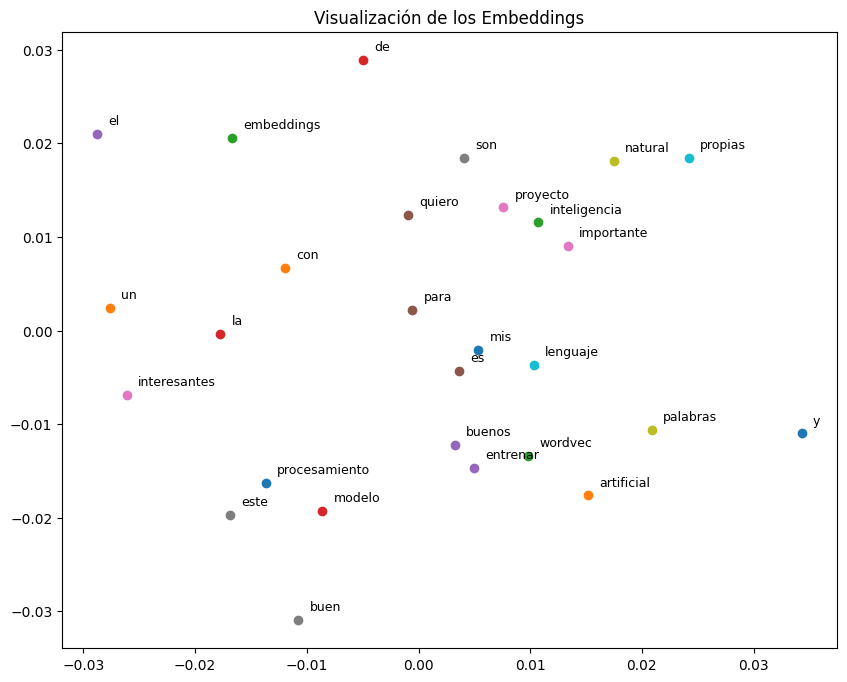

In [6]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Obtenemos la lista de TODAS las palabras que el modelo aprendió
palabras = model_cargado.wv.index_to_key

# Obtenemos el vector de cada palabra
vectores = [model_cargado.wv[w] for w in palabras]

# Reducimos las dimensiones: (el tamaño de tu vector)D -> 2D
pca = PCA(n_components = 2)
reduc = pca.fit_transform(vectores)

# Graficamos
plt.figure(figsize = (10, 8)) # Hacemos la gráfica un poco más grande
for i, word in enumerate(palabras):
  x, y = reduc[i]
  plt.scatter(x, y)
  # Ajustamos la posición y tamaño del texto para que se lea mejor
  plt.text(x + 0.001, y + 0.001, word, fontsize = 9)

plt.title("Visualización de los Embeddings")
plt.show()